<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/CNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN from scratch

In this section, we'll train a CNN from scratch using a dataset stored in a zip file. We'll conduct experiments with increasingly complex neural networks to analyze the results.

## Import libraries

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime

## Unzip preprocessed dataset

In [ ]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"

Mounted at /content/drive/


## Parameters definition


Definition of the paths for each dataset and choice of the size to be used for the images.

In [ ]:
dataset_path = "/content/dataset/content/splitted_dataset"

training_path = os.path.join(dataset_path, "training_set")
validation_path = os.path.join(dataset_path, "validation_set")
test_path = os.path.join(dataset_path, "test_set")

models_path = "/content/drive/My Drive/project/models"
if not os.path.exists(models_path):
  os.makedirs(models_path)

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 128
NUM_CLASSES = 8
RANDOM_SEED = 42

## Load dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.


# Utility methods

A function to define the callbacks_list and train the model.

In [ ]:
def compile_and_fit(model, model_name, model_path, learning_rate=None, optimizer='adam'):

  if not os.path.exists(model_path):
    os.makedirs(model_path)

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,), 
    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks_list)    
  plot_accuracy_loss(history)

A function to plot accuracy and loss, both for training set and validation set.

In [ ]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

A function to evaluate the model against the test set.

In [ ]:
def eval (model):
  y_score = model.predict(test_dataset)
  test_loss, test_acc = model.evaluate(test_dataset)
  print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))

# CNN Implementation

In this section, we'll train the model using a standard CNN, gradually adding complexity to the network and comparing the results. To reduce overfitting, we'll also apply techniques such as normalization, data augmentation, and dropouts.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

## Model 1: Standard CNN

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                         

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.7952 - accuracy: 0.3395
Epoch 1: val_loss improved from inf to 1.73453, saving model to /content/drive/My Drive/project/models/standardCNN/standardCNN.h5
55/55 [==============================] - 31s 308ms/step - loss: 1.7952 - accuracy: 0.3395 - val_loss: 1.7345 - val_accuracy: 0.3404
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.4043 - accuracy: 0.4974
Epoch 2: val_loss improved from 1.73453 to 1.34222, saving model to /content/drive/My Drive/project/models/standardCNN/standardCNN.h5
55/55 [==============================] - 16s 274ms/step - loss: 1.4043 - accuracy: 0.4974 - val_loss: 1.3422 - val_accuracy: 0.5483
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.2711 - accuracy: 0.5538
Epoch 3: val_loss did not improve from 1.34222
55/55 [==============================] - 16s 278ms/step - loss: 1.2711 - accuracy: 0.5538 - val_loss: 1.4042 - val_accuracy: 0.5307
Epoch 4/

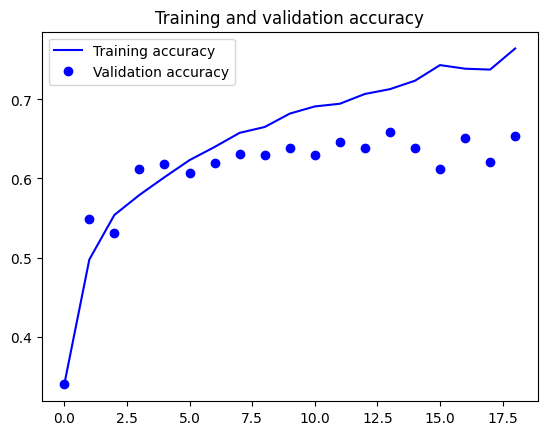

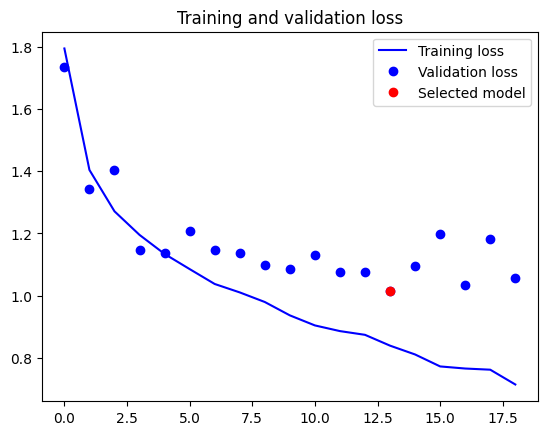

Lowest validation loss has been reached at epoch 13 with validation accuracy of 0.658


In [ ]:
model_name = "standardCNN"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 3s 169ms/step - loss: 0.9645 - accuracy: 0.6727
Test accuracy: 0.673, test loss: 0.965
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.1575    0.7755    0.2618       147
           1     0.9475    0.6817    0.7929      1112
           2     0.7770    0.3979    0.5263       289
           3     0.3913    0.1837    0.2500        98
           4     0.6448    0.7152    0.6782       165
           5     0.6964    0.5417    0.6094       288
           6     0.5507    0.2901    0.3800       131
           7     0.4701    0.6429    0.5431        98

    accuracy                         0.5928      2328
   macro avg     0.5794    0.5286    0.5052      2328
weighted avg     0.7581    0.5928    0.6388      2328



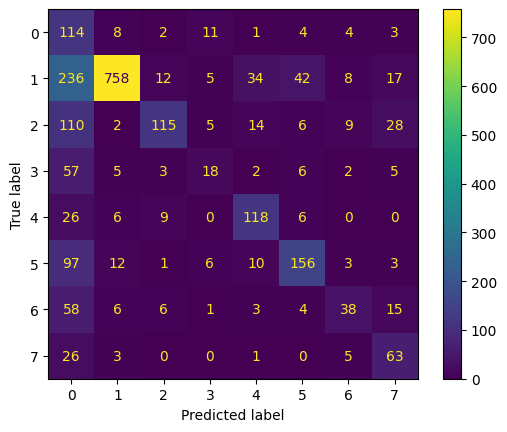

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Considerations

The model quickly begins to overfit, and after epoch 5, there are no improvements in validation loss. This is likely due to the model's simplicity, and we need to add more layers to increase its depth and improve its performance.

## Model 2: One dense layer and four Conv2D layers

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                       

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.9667 - accuracy: 0.2200
Epoch 1: val_loss improved from inf to 1.91842, saving model to /content/drive/My Drive/project/models/OneDense4Conv2D/OneDense4Conv2D.h5
55/55 [==============================] - 20s 300ms/step - loss: 1.9667 - accuracy: 0.2200 - val_loss: 1.9184 - val_accuracy: 0.1577
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.6970 - accuracy: 0.3497
Epoch 2: val_loss improved from 1.91842 to 1.79548, saving model to /content/drive/My Drive/project/models/OneDense4Conv2D/OneDense4Conv2D.h5
55/55 [==============================] - 16s 281ms/step - loss: 1.6970 - accuracy: 0.3497 - val_loss: 1.7955 - val_accuracy: 0.2750
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.5778 - accuracy: 0.4161
Epoch 3: val_loss improved from 1.79548 to 1.63314, saving model to /content/drive/My Drive/project/models/OneDense4Conv2D/OneDense4Conv2D.h5
55/55 [======================

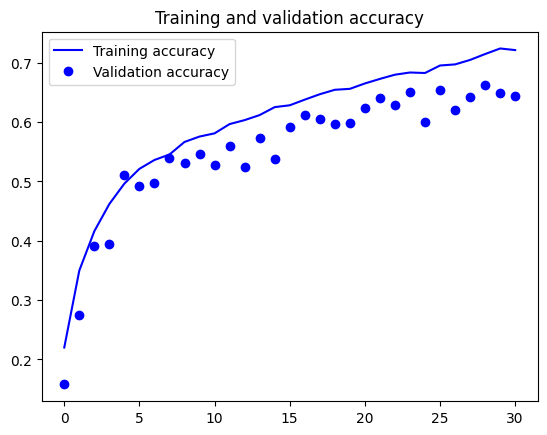

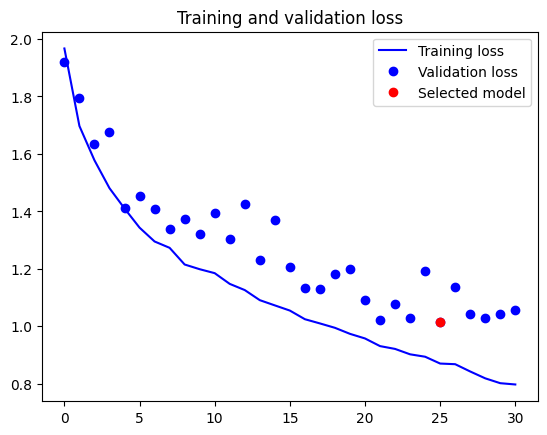

Lowest validation loss has been reached at epoch 25 with validation accuracy of 0.653


In [ ]:
model_name = "OneDense4Conv2D"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 4s 180ms/step - loss: 0.9603 - accuracy: 0.6701
Test accuracy: 0.670, test loss: 0.960
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 3]
              precision    recall  f1-score   support

           0     0.1560    0.8163    0.2620       147
           1     0.9620    0.6376    0.7669      1112
           2     0.7802    0.4913    0.6030       289
           3     0.3861    0.3980    0.3920        98
           4     0.6875    0.6667    0.6769       165
           5     0.6053    0.5590    0.5812       288
           6     0.5532    0.1985    0.2921       131
           7     0.7576    0.5102    0.6098        98

    accuracy                         0.5829      2328
   macro avg     0.6110    0.5347    0.5230      2328
weighted avg     0.7691    0.5829    0.6362      2328



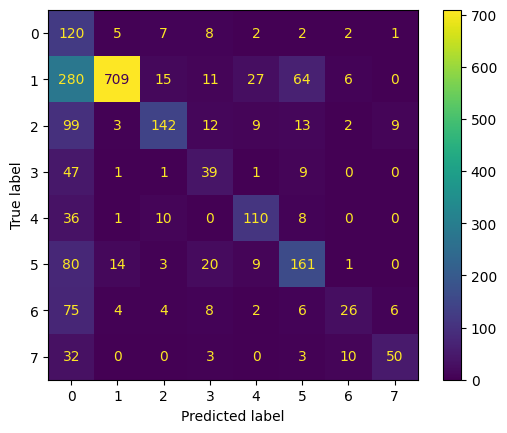

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Considerations


The dense layer allows us to reduce overfitting and it slightly increases the prediction power. Now we need to minimize the overfitting by adding dropout layers.

##Model 3: One Dropout and Dense layer

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                       

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.9740 - accuracy: 0.2138
Epoch 1: val_loss improved from inf to 1.77814, saving model to /content/drive/My Drive/project/models/OneDropout64Dense/OneDropout64Dense.h5
55/55 [==============================] - 20s 304ms/step - loss: 1.9740 - accuracy: 0.2138 - val_loss: 1.7781 - val_accuracy: 0.3262
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.7710 - accuracy: 0.3132
Epoch 2: val_loss improved from 1.77814 to 1.65514, saving model to /content/drive/My Drive/project/models/OneDropout64Dense/OneDropout64Dense.h5
55/55 [==============================] - 17s 283ms/step - loss: 1.7710 - accuracy: 0.3132 - val_loss: 1.6551 - val_accuracy: 0.4001
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.6656 - accuracy: 0.3679
Epoch 3: val_loss improved from 1.65514 to 1.62952, saving model to /content/drive/My Drive/project/models/OneDropout64Dense/OneDropout64Dense.h5
55/55 [==========

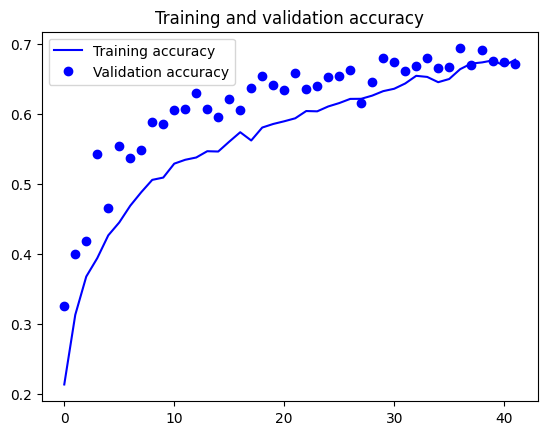

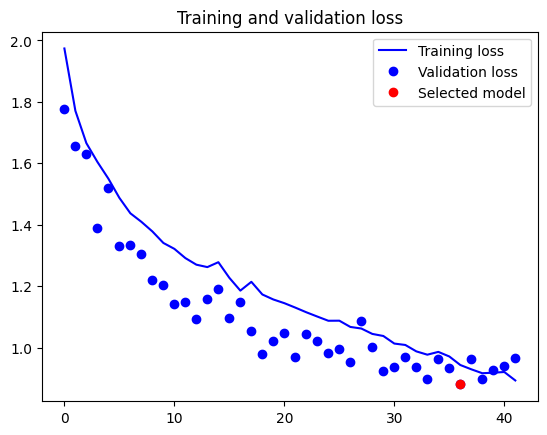

Lowest validation loss has been reached at epoch 36 with validation accuracy of 0.694


In [ ]:
model_name = "OneDropout64Dense"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 4s 182ms/step - loss: 0.8431 - accuracy: 0.7045
Test accuracy: 0.704, test loss: 0.843
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.1640    0.8367    0.2742       147
           1     0.9580    0.6969    0.8069      1112
           2     0.8023    0.4775    0.5987       289
           3     0.5227    0.2347    0.3239        98
           4     0.6507    0.8242    0.7273       165
           5     0.7143    0.5035    0.5906       288
           6     0.6724    0.2977    0.4127       131
           7     0.6867    0.5816    0.6298        98

    accuracy                         0.6168      2328
   macro avg     0.6464    0.5566    0.5455      2328
weighted avg     0.7908    0.6168    0.6650      2328



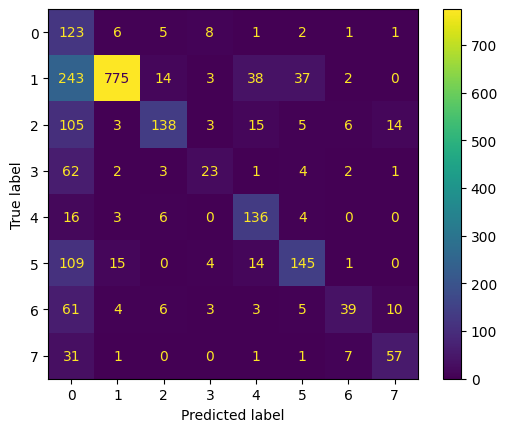

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Consideration

The dropout layer, along with the size of the network, leads to an underfitting condition. Therefore, the solution is to increase the size of the network by adding a dense layer. 
The performances compared to the previous models are better both on the validation and on the test set. 

##Model 4: Two Dropout and Dense layer

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                      

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 2.0180 - accuracy: 0.2028
Epoch 1: val_loss improved from inf to 1.91696, saving model to /content/drive/My Drive/project/models/TwoDropout128Dense/TwoDropout128Dense.h5
55/55 [==============================] - 19s 292ms/step - loss: 2.0180 - accuracy: 0.2028 - val_loss: 1.9170 - val_accuracy: 0.1839
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.7263 - accuracy: 0.3348
Epoch 2: val_loss improved from 1.91696 to 1.62460, saving model to /content/drive/My Drive/project/models/TwoDropout128Dense/TwoDropout128Dense.h5
55/55 [==============================] - 17s 288ms/step - loss: 1.7263 - accuracy: 0.3348 - val_loss: 1.6246 - val_accuracy: 0.4293
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.5679 - accuracy: 0.4205
Epoch 3: val_loss improved from 1.62460 to 1.51191, saving model to /content/drive/My Drive/project/models/TwoDropout128Dense/TwoDropout128Dense.h5
55/55 [====

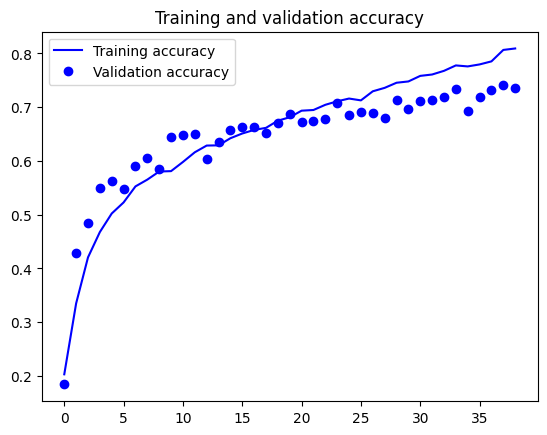

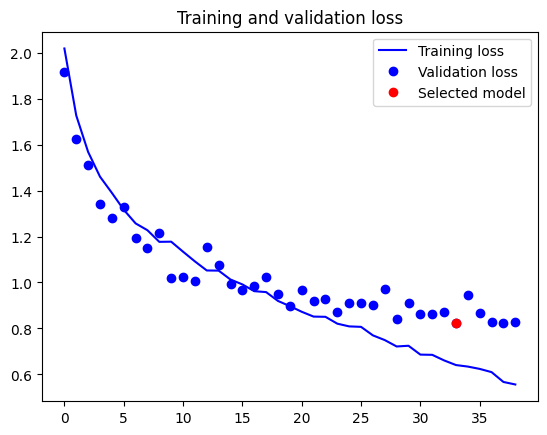

Lowest validation loss has been reached at epoch 33 with validation accuracy of 0.734


In [ ]:
model_name = "TwoDropout128Dense"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 4s 168ms/step - loss: 0.7653 - accuracy: 0.7534
Test accuracy: 0.753, test loss: 0.765
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 3]
              precision    recall  f1-score   support

           0     0.2138    0.8435    0.3411       147
           1     0.9718    0.7446    0.8432      1112
           2     0.8621    0.5190    0.6479       289
           3     0.6076    0.4898    0.5424        98
           4     0.6816    0.8303    0.7486       165
           5     0.7854    0.6354    0.7025       288
           6     0.5574    0.5191    0.5375       131
           7     0.7126    0.6327    0.6703        98

    accuracy                         0.6873      2328
   macro avg     0.6740    0.6518    0.6292      2328
weighted avg     0.8171    0.6873    0.7260      2328



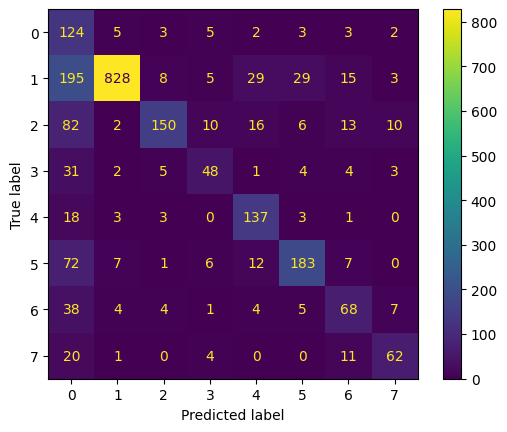

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Consideration

By using two Dense layers with 128 and 256 units respectively, the model is able to improve the results of the previous CNNs on both the validation and test sets. The Dense layers allow the model to learn the more complex relationships between the input data features, while the two dropout layers help to minimize overfitting.

## Model 5: Normalization layer

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)

x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=4)(x)

x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 64)        1849

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.9155 - accuracy: 0.3388
Epoch 1: val_loss improved from inf to 2.43220, saving model to /content/drive/My Drive/project/models/BatchNormalizationLayer/BatchNormalizationLayer.h5
55/55 [==============================] - 23s 322ms/step - loss: 1.9155 - accuracy: 0.3388 - val_loss: 2.4322 - val_accuracy: 0.1298
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.4689 - accuracy: 0.4837
Epoch 2: val_loss did not improve from 2.43220
55/55 [==============================] - 16s 281ms/step - loss: 1.4689 - accuracy: 0.4837 - val_loss: 2.7309 - val_accuracy: 0.1302
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.3377 - accuracy: 0.5348
Epoch 3: val_loss did not improve from 2.43220
55/55 [==============================] - 17s 284ms/step - loss: 1.3377 - accuracy: 0.5348 - val_loss: 2.8145 - val_accuracy: 0.1435
Epoch 4/100
55/55 [==============================] - ETA: 0s - loss: 1.

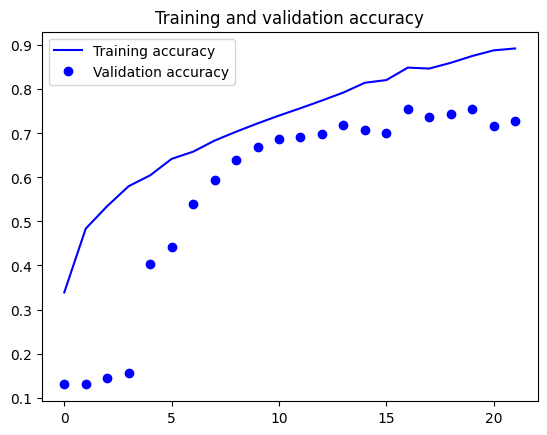

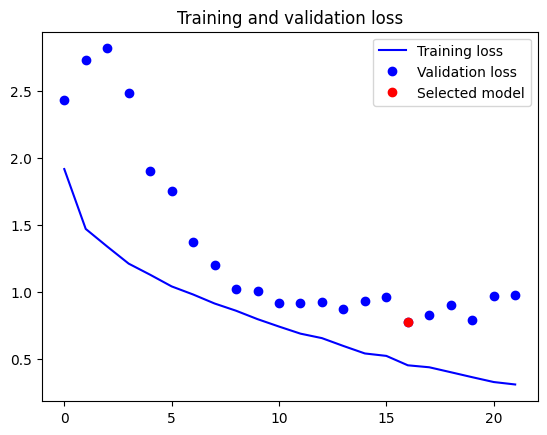

Lowest validation loss has been reached at epoch 16 with validation accuracy of 0.756


In [ ]:
model_name = "BatchNormalizationLayer"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 5s 246ms/step - loss: 0.6916 - accuracy: 0.7719
Test accuracy: 0.772, test loss: 0.692
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 3]
              precision    recall  f1-score   support

           0     0.2662    0.8095    0.4007       147
           1     0.9740    0.7743    0.8627      1112
           2     0.8851    0.5329    0.6652       289
           3     0.5495    0.6224    0.5837        98
           4     0.7302    0.8364    0.7797       165
           5     0.7574    0.8021    0.7791       288
           6     0.6783    0.5954    0.6341       131
           7     0.6602    0.6939    0.6766        98

    accuracy                         0.7345      2328
   macro avg     0.6876    0.7084    0.6727      2328
weighted avg     0.8265    0.7345    0.7604      2328



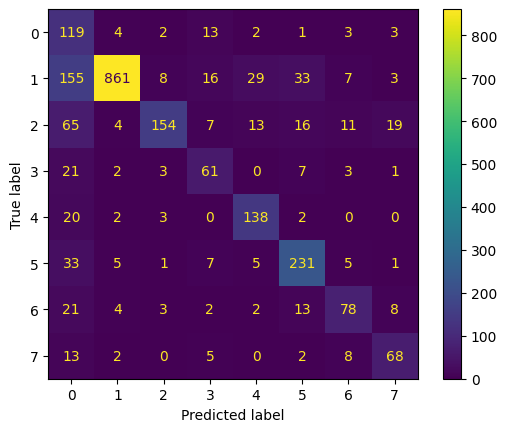

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Consideration

##Model 6: Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.2), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.1), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
])

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = data_augmentation(inputs)
x = resize_and_rescale(x)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 56, 56, 64)        18496     
                                                           

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 2.0386 - accuracy: 0.1844
Epoch 1: val_loss improved from inf to 1.98813, saving model to /content/drive/My Drive/project/models/DataAugmentationLayer/DataAugmentationLayer.h5
55/55 [==============================] - 20s 291ms/step - loss: 2.0386 - accuracy: 0.1844 - val_loss: 1.9881 - val_accuracy: 0.1143
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.7722 - accuracy: 0.3135
Epoch 2: val_loss improved from 1.98813 to 1.63939, saving model to /content/drive/My Drive/project/models/DataAugmentationLayer/DataAugmentationLayer.h5
55/55 [==============================] - 17s 285ms/step - loss: 1.7722 - accuracy: 0.3135 - val_loss: 1.6394 - val_accuracy: 0.4108
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.6122 - accuracy: 0.3912
Epoch 3: val_loss improved from 1.63939 to 1.53427, saving model to /content/drive/My Drive/project/models/DataAugmentationLayer/DataAugmentationLa

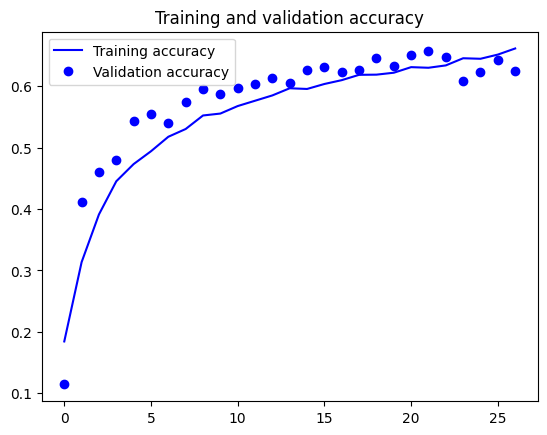

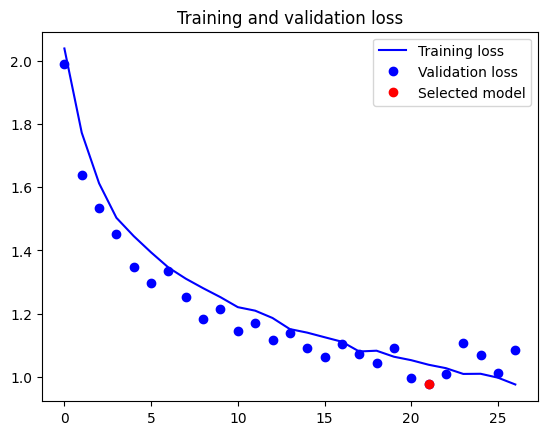

Lowest validation loss has been reached at epoch 21 with validation accuracy of 0.657


In [ ]:
model_name = "DataAugmentationLayer"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 4s 200ms/step - loss: 0.9457 - accuracy: 0.6723
Test accuracy: 0.672, test loss: 0.946
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.1664    0.8639    0.2791       147
           1     0.9558    0.6799    0.7945      1112
           2     0.9027    0.3529    0.5075       289
           3     0.3333    0.2245    0.2683        98
           4     0.6720    0.7576    0.7123       165
           5     0.6113    0.5625    0.5859       288
           6     0.7561    0.2366    0.3605       131
           7     0.5825    0.6122    0.5970        98

    accuracy                         0.5949      2328
   macro avg     0.6225    0.5363    0.5131      2328
weighted avg     0.7835    0.5949    0.6398      2328



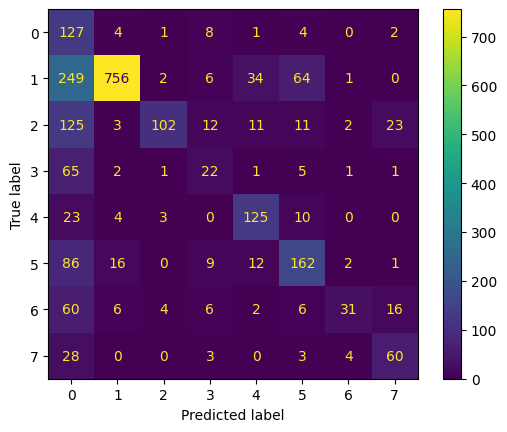

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Considerations